In [1]:
!pip install transformers datasets torch scikit-learn pandas

Label mapping: {'drug and alcohol': np.int64(0), 'early life': np.int64(1), 'personality': np.int64(2), 'trauma and stress': np.int64(3)}


Map:   0%|          | 0/658 [00:00<?, ? examples/s]

Map:   0%|          | 0/165 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1248113681.py:156: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.362800,1.212084,0.503030,0.452838
2,0.902800,0.770999,0.739394,0.744653
3,0.513000,0.906463,0.715152,0.711062
4,0.346500,0.806547,0.751515,0.756001
5,0.241900,0.859875,0.745455,0.744653


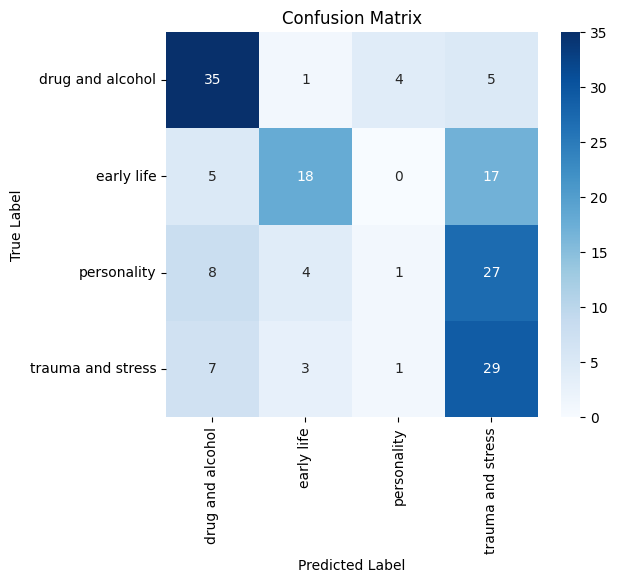


Classification Report:
                    precision    recall  f1-score   support

 drug and alcohol       0.64      0.78      0.70        45
       early life       0.69      0.45      0.55        40
      personality       0.17      0.03      0.04        40
trauma and stress       0.37      0.72      0.49        40

         accuracy                           0.50       165
        macro avg       0.47      0.49      0.45       165
     weighted avg       0.47      0.50      0.45       165


Per-Class Accuracy:
drug and alcohol: 0.778
early life: 0.450
personality: 0.025
trauma and stress: 0.725


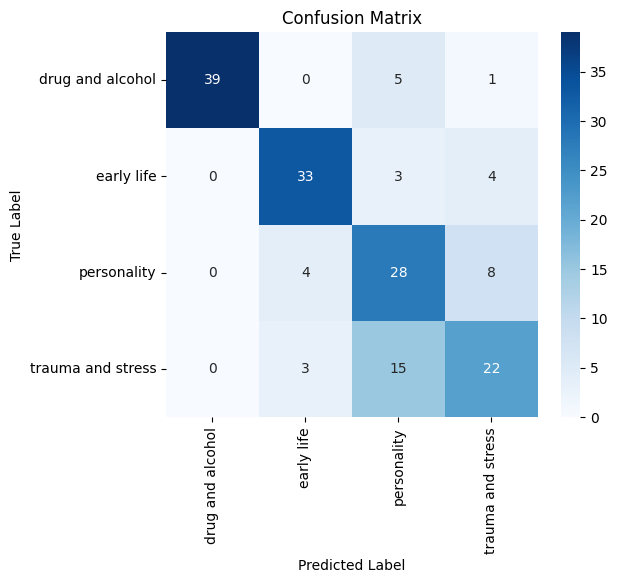


Classification Report:
                    precision    recall  f1-score   support

 drug and alcohol       1.00      0.87      0.93        45
       early life       0.82      0.82      0.82        40
      personality       0.55      0.70      0.62        40
trauma and stress       0.63      0.55      0.59        40

         accuracy                           0.74       165
        macro avg       0.75      0.74      0.74       165
     weighted avg       0.76      0.74      0.74       165


Per-Class Accuracy:
drug and alcohol: 0.867
early life: 0.825
personality: 0.700
trauma and stress: 0.550


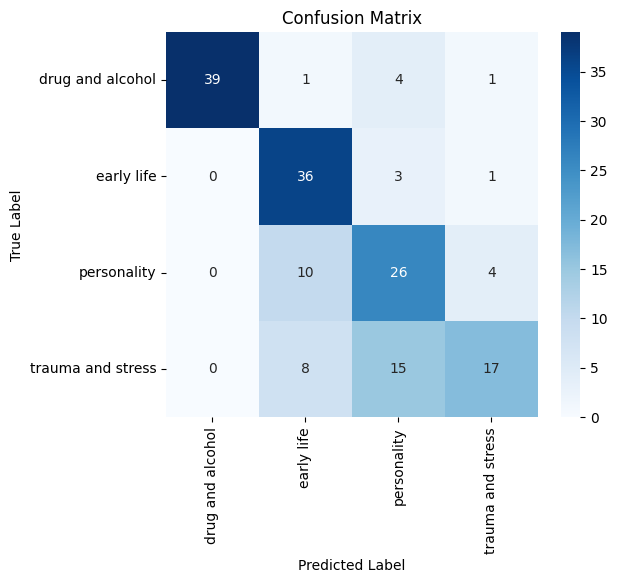


Classification Report:
                    precision    recall  f1-score   support

 drug and alcohol       1.00      0.87      0.93        45
       early life       0.65      0.90      0.76        40
      personality       0.54      0.65      0.59        40
trauma and stress       0.74      0.42      0.54        40

         accuracy                           0.72       165
        macro avg       0.73      0.71      0.70       165
     weighted avg       0.74      0.72      0.71       165


Per-Class Accuracy:
drug and alcohol: 0.867
early life: 0.900
personality: 0.650
trauma and stress: 0.425


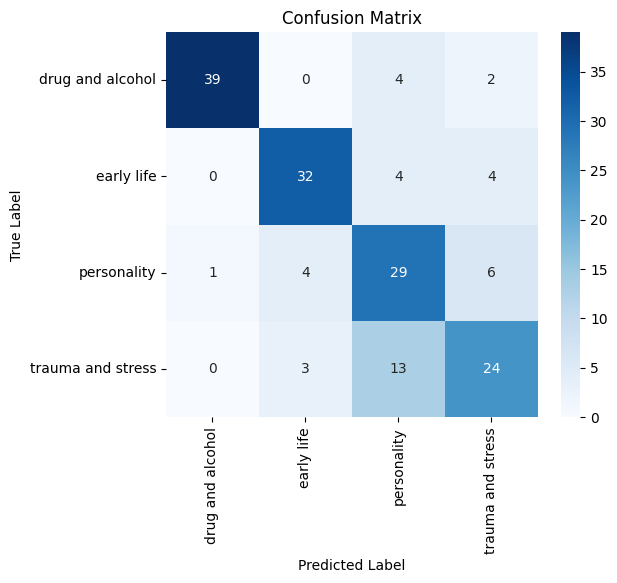


Classification Report:
                    precision    recall  f1-score   support

 drug and alcohol       0.97      0.87      0.92        45
       early life       0.82      0.80      0.81        40
      personality       0.58      0.72      0.64        40
trauma and stress       0.67      0.60      0.63        40

         accuracy                           0.75       165
        macro avg       0.76      0.75      0.75       165
     weighted avg       0.77      0.75      0.76       165


Per-Class Accuracy:
drug and alcohol: 0.867
early life: 0.800
personality: 0.725
trauma and stress: 0.600


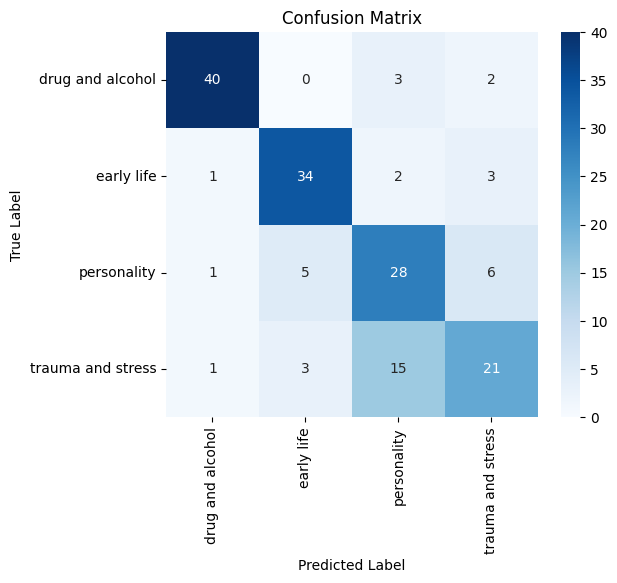


Classification Report:
                    precision    recall  f1-score   support

 drug and alcohol       0.93      0.89      0.91        45
       early life       0.81      0.85      0.83        40
      personality       0.58      0.70      0.64        40
trauma and stress       0.66      0.53      0.58        40

         accuracy                           0.75       165
        macro avg       0.74      0.74      0.74       165
     weighted avg       0.75      0.75      0.74       165


Per-Class Accuracy:
drug and alcohol: 0.889
early life: 0.850
personality: 0.700
trauma and stress: 0.525

Evaluating Final Model on Test Set...


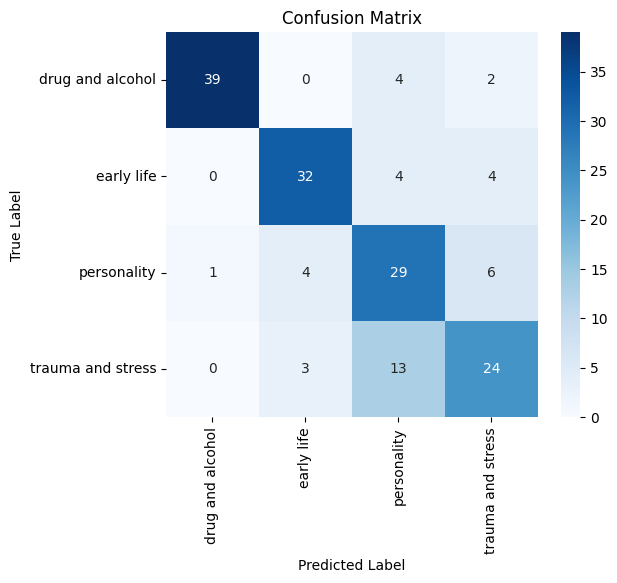


Classification Report:
                    precision    recall  f1-score   support

 drug and alcohol       0.97      0.87      0.92        45
       early life       0.82      0.80      0.81        40
      personality       0.58      0.72      0.64        40
trauma and stress       0.67      0.60      0.63        40

         accuracy                           0.75       165
        macro avg       0.76      0.75      0.75       165
     weighted avg       0.77      0.75      0.76       165


Per-Class Accuracy:
drug and alcohol: 0.867
early life: 0.800
personality: 0.725
trauma and stress: 0.600

Final Test Results: {'eval_loss': 0.8065474033355713, 'eval_accuracy': 0.7515151515151515, 'eval_f1': 0.7560007067315919, 'eval_runtime': 1.4007, 'eval_samples_per_second': 117.799, 'eval_steps_per_second': 14.993, 'epoch': 5.0}

Model and tokenizer saved in './final_bert_model'


In [ ]:
# ==============================
# IMPORTS
# ==============================
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

os.environ["WANDB_DISABLED"] = "true"

df1 = pd.read_csv("LDDA1.csv")
df2 = pd.read_csv("LDEL1.csv")
df3 = pd.read_csv("LDTS1.csv")
df4 = pd.read_csv("LDPF1.csv")

def assign_label(df, label_text):
    df["Label"] = label_text
    return df

df1 = assign_label(df1, "drug and alcohol")
df2 = assign_label(df2, "early life")
df3 = assign_label(df3, "trauma and stress")
df4 = assign_label(df4, "personality")

df = pd.concat([df1, df2, df3, df4], ignore_index=True)

df["text"] = df["title"].fillna('') + " " + df["selftext"].fillna('')
df = df[["text", "Label"]].dropna()
df["Label"] = df["Label"].str.strip().str.lower()

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Label"])
label_names = label_encoder.classes_
print("Label mapping:", dict(zip(label_names, label_encoder.transform(label_names))))

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_names))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")

    precision, recall, f1_per_class, support = precision_recall_fscore_support(labels, preds, labels=range(len(label_names)))
    report = classification_report(labels, preds, target_names=label_names, output_dict=True)

    confusion = confusion_matrix(labels, preds)
    per_class_accuracy = confusion.diagonal() / confusion.sum(axis=1).astype(float)

    plt.figure(figsize=(6,5))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("\nClassification Report:\n", classification_report(labels, preds, target_names=label_names))
    print("\nPer-Class Accuracy:")
    for name, acc_class in zip(label_names, per_class_accuracy):
        print(f"{name}: {acc_class:.3f}")

    metrics_dict = {
        "accuracy": acc,
        "weighted_f1": f1,
        "macro_avg": report["macro avg"],
        "weighted_avg": report["weighted avg"],
        "per_class_metrics": report,
        "per_class_accuracy": dict(zip(label_names, per_class_accuracy.tolist()))
    }
    with open("epoch_metrics.json", "a") as f:
        f.write(json.dumps(metrics_dict, indent=2))
        f.write("\n\n")

    return {"accuracy": acc, "f1": f1}

training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_strategy="epoch",
    save_total_limit=3,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_output = trainer.train()

print("\nEvaluating Final Model on Test Set...")
results = trainer.evaluate()
print("\nFinal Test Results:", results)

model.save_pretrained("./final_bert_model")
tokenizer.save_pretrained("./final_bert_model")
print("\nModel and tokenizer saved in './final_bert_model'")

In [ ]:
import os
import shutil

directory_to_zip = "./final_bert_model"
zip_file_name = "final_bert_model"

shutil.make_archive(zip_file_name, 'zip', directory_to_zip)

print(f"Directory '{directory_to_zip}' zipped successfully as '{zip_file_name}.zip'")

Directory './final_bert_model' zipped successfully as 'final_bert_model.zip'


In [ ]:

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.preprocessing import LabelEncoder

model_path = "./final_bert_model"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.eval()

label_encoder = LabelEncoder()
label_encoder.fit(["drug and alcohol", "early life", "personality", "trauma and stress"])
label_names = label_encoder.classes_

def predict_text(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).item()

    return label_names[preds]

print("💬 Mental Health Cause Detector — type 'exit' to stop\n")
while True:
    user_input = input("Enter a sentence: ").strip()
    if user_input.lower() == "exit":
        print("Exiting...")
        break
    label = predict_text(user_input)
    print(f"🔹 Predicted Label: {label}\n")


💬 Mental Health Cause Detector — type 'exit' to stop

Enter a sentence: exit
Exiting...
